In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
import nltk
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel, LsiModel, LdaModel, HdpModel
import pyLDAvis.gensim
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')

In [2]:
df = pd.read_excel('RealEstate.xlsx')
df

,web_id,property_text_en
0,7023850,Smart Business Real Estate is proud to present...
1,6905802,My Island Real Estate is proud to present 1 Be...
2,6998469,"New on the market, amazing opportunity for inv..."
3,6766136,1 Bedroom Apartment in Marina Diamond 2\n\n- 1...
4,6940244,No penalty for early contract termination!<br ...
...,...,...
756,6203680,Castles Plaza Real Estate is pleased to bring ...
757,7090736,The Noble House Real Estate is proud to presen...
758,7081426,Better Homes would like to present this type 2...
759,7123539,Morgan‚Äôs International Realty is proud to pr...


#### Inspecting the first 8 entries

In [3]:
# Inspecting the first 8 entries
for entry in df.loc[0:8,'property_text_en']:
    print(entry)
    print()
    print()

Smart Business Real Estate is proud to present2Bedrooms for sale locatedat Dubai MarinaElite Residenceon mid floor over looking court yard.\n\nProperty currently Rentedat AED 110,000 till25 of June 2020.\n\nElite Residenceis ideally locatedat the middle of Dubai Marina area , close to the Tran stationas well Metro stationnear by .surrounding by lots of cafe and restaurants , Marina Walkpromenade , across streetfew5 *Hotels. Dubai Marinais very popularand most desirable place to live.\n\nAt the building available facilities:\nGym\nPool\nSecurity 24/7\nCovered parking .\n\nFor more information or viewing appointment, call:\nSmart Business Real Estate LLC\nLandline:+971 4 5808525 / 0503474100\nEmail: info@sbrealestate.ae\nBRN 11575\nORN 2104


My Island Real Estate is proud to present 1 Bedroom Apt. in Dubai Marina with Partial Sea View\n\n\nDubai Marina\nPrincess Tower\n1 Bedroom Apartment\nPartial Sea View\n922.68 sqft\nUnfurnished Apartment\n\n\n\nFor more details, please call 056-9576

#### Here we notice the text includes a lot of:
- html
- '\n' which means new line
- phone numbers starting with + sign 
    - many formats
    - +xxx xx xxx xxxx
    - +xxx x xxx xxxx
    - +xxxxxxxxxxxx
    - xxxxx (continuous block of numbers)
    - xxxx,xxxx
- special characters
- emails

So we need to preprocess the data and clean it

### Method for getting the relevant pos tag

In [4]:
from nltk.corpus import wordnet
# method used to get the correct pos tag for correct lemmatization since nltk assumes all words are nouns which results in wrong lemmatization without specifying the correct pos
def get_pos(word):
    # WordNet Lemmatizer needs a pos to correctly lemmatize words. 
    # WordNet accepts pos in formats: 'wordnet.NOUN' 'wordnet.VERB' 'wordnet.ADJ' 'wordnet.ADV' for noun, verb, adj, adverb, respectively
    # to map nltk pos tags to wordnet pos tags we get the first letter out of the nltk pos tag and map it to a wordnet tag

    # get the nltk pos tag 
    pos = nltk.pos_tag([word])
    #outputs: [('playing', 'VBG')]

    # get the first letter of the nltk pos tag
    pos = pos[0][1][0]

    pos_tags = {
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "J": wordnet.ADJ,
        "R": wordnet.ADV,
        "default": wordnet.NOUN
    }
    # if the pos tag doesnt match any key, return wordnet.NOUN as a default
    return pos_tags.get(pos, pos_tags['default'])

In [5]:
# Preprocessing each document
def preprocessing(document):
    document = document.lower()

    #removing the html
    document = re.sub(r'(\<[ ]?[a-z]+>|\<\/[a-z]+\>)', ' ', document)
    # noticed that '<' stayed for some reason, so removing them
    document = re.sub(r'<', ' ', document)
    #
    # removing emails
    document = re.sub(r'\S+@\S+', ' ', document)
    # removing \n
    document = re.sub(r'(\\n)', " ", document)
    # removing numbers of this formats:
    # - xxxx,xxxx (numbers with commas)
    document = re.sub(r'(\d+),(\d+),?(\d*)', " ", document)
    # removing numbers of all other formats
    document = re.sub(r'(\+)?\d+[ ]?\d*[ ]?\d*[ ]?\d*', ' ', document)
    # removing characters like ? ! : ; \n \
    document = re.sub('[*.?!,:;/&]', ' ', document)
    # removal of --
    document = re.sub(r'--'," ", document)
    # removal of word 'dubai'
    #document = re.sub(r'dubai'," ", document)

    document = " ".join([word for word in document.split() if len(word) > 3 ])
    
    document = " ".join([word for word in document.split() if word not in stop_words])

    document = " ".join([WordNetLemmatizer().lemmatize(word) for word in document.split()])

    return document

In [6]:
# apply the method on the documents column
df['property_text_en'] = df['property_text_en'].apply(preprocessing)

#### Preparing inputs for the LSI model

In [7]:
text = df['property_text_en'].tolist()
text = [nltk.word_tokenize(doc) for doc in text]

In [8]:
# preparing inputs for the LSI model
dictionary = corpora.Dictionary(text)
corpus = [dictionary.doc2bow(doc) for doc in text]

In [9]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [10]:
lsimodel.show_topics(num_topics=10)

[(0,
  '0.405*"dubai" + 0.393*"marina" + 0.221*"apartment" + 0.212*"tower" + 0.195*"bedroom" + 0.182*"room" + 0.178*"view" + 0.172*"area" + 0.165*"property" + 0.157*"floor"'),
 (1,
  '0.363*"marina" + 0.300*"dubai" + -0.268*"bedroom" + -0.258*"property" + -0.213*"room" + 0.167*"tower" + -0.161*"study" + -0.141*"bathroom" + -0.141*"garden" + -0.138*"villa"'),
 (2,
  '-0.504*"tower" + -0.341*"princess" + -0.301*"floor" + 0.289*"marina" + 0.175*"dubai" + -0.159*"residential" + 0.152*"property" + -0.152*"tallest" + -0.130*"world" + 0.125*"walk"'),
 (3,
  '-0.432*"elite" + -0.425*"residence" + 0.232*"estate" + 0.232*"real" + -0.212*"room" + 0.195*"property" + 0.173*"dubai" + 0.160*"marina" + 0.150*"tower" + -0.145*"pool"'),
 (4,
  '0.404*"real" + 0.402*"estate" + 0.314*"elite" + 0.298*"residence" + -0.174*"marina" + 0.165*"service" + -0.162*"room" + 0.154*"property" + -0.149*"apartment" + -0.127*"bedroom"'),
 (5,
  '0.380*"room" + 0.346*"dubai" + -0.198*"marina" + -0.166*"walk" + -0.160*"to

In [11]:
coherence_model_lsi = CoherenceModel(model=lsimodel, texts=text, dictionary=dictionary, coherence='c_v')
lsi_coherence = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', lsi_coherence)



Coherence Score:  0.4308714571863318


So we got a coherence score of 0.4


### Using LDA model

In [24]:
lda_model = LdaModel(corpus = corpus, id2word= dictionary, num_topics= 10,alpha= 'auto')
lda_model.show_topics()

[(0,
  '0.027*"marina" + 0.019*"dubai" + 0.016*"bedroom" + 0.016*"property" + 0.015*"real" + 0.013*"estate" + 0.013*"tower" + 0.012*"apartment" + 0.012*"area" + 0.012*"view"'),
 (1,
  '0.025*"dubai" + 0.023*"marina" + 0.019*"property" + 0.015*"room" + 0.014*"area" + 0.013*"bedroom" + 0.011*"apartment" + 0.010*"pool" + 0.009*"view" + 0.008*"offer"'),
 (2,
  '0.027*"marina" + 0.025*"dubai" + 0.018*"property" + 0.017*"apartment" + 0.016*"bedroom" + 0.013*"view" + 0.013*"area" + 0.010*"tower" + 0.008*"residence" + 0.008*"pool"'),
 (3,
  '0.026*"dubai" + 0.019*"marina" + 0.017*"property" + 0.015*"tower" + 0.013*"floor" + 0.012*"bedroom" + 0.011*"view" + 0.011*"area" + 0.010*"apartment" + 0.009*"pool"'),
 (4,
  '0.043*"marina" + 0.023*"dubai" + 0.016*"apartment" + 0.016*"tower" + 0.013*"bedroom" + 0.012*"area" + 0.011*"walk" + 0.011*"view" + 0.011*"floor" + 0.011*"room"'),
 (5,
  '0.030*"dubai" + 0.021*"marina" + 0.017*"tower" + 0.015*"apartment" + 0.013*"room" + 0.012*"area" + 0.012*"floor"

In [25]:
# topic distribution for document id 308
lda_model.get_document_topics(corpus[308])

[(4, 0.25141004), (9, 0.73695767)]

### Visualizing the results using pyLDAvis

In [26]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.002324 -0.007123       1        1  19.436948
4      0.017817 -0.018993       2        1  18.047591
7      0.025564 -0.013855       3        1  13.088203
9     -0.000876 -0.004008       4        1  10.083698
2      0.002495  0.012360       5        1   9.330183
8     -0.043176  0.002769       6        1   7.790233
6     -0.005913 -0.037569       7        1   7.693032
0      0.000480  0.018821       8        1   6.679166
1      0.031199  0.030686       9        1   4.833911
3     -0.025266  0.016912      10        1   3.017035, topic_info=         Term         Freq        Total Category  logprob  loglift
39   property   858.000000   858.000000  Default  30.0000  30.0000
14      dubai  1859.000000  1859.000000  Default  29.0000  29.0000
29     marina  1821.000000  1821.000000  Default  28.0000  28.0000
106     tower  1012.000000  1012.000000  Default  27.0000  27.0000
147      room   959.000000   959.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
5    building    12.461786   433.653721  Topic10  -5.2205  -0.0487
57       well     9.812852   279.653405  Topic10  -5.4594   0.1510
120   balcony    10.743467   369.945339  Topic10  -5.3688  -0.0382
152  swimming    11.149758   435.147862  Topic10  -5.3317  -0.1634
34    parking    11.238262   522.111704  Topic10  -5.3238  -0.3377

[821 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
327       1  0.231825           's
327       2  0.123157           's
327       3  0.144891           's
327       4  0.210091           's
327       5  0.086934           's
...     ...       ...          ...
2463      5  0.219907  ‚ñ∫built-in
2468      1  0.359223    ‚ñ∫vacant
2469      1  0.670118       ‚ô¶‚ô¶
2469      5  0.167530       ‚ô¶‚ô¶
2469      9  0.083765       ‚ô¶‚ô¶

[2404 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 8, 10, 3, 9, 7, 1, 2, 4])

In [28]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=text, dictionary=dictionary, coherence='c_v')
lda_coherence = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', lda_coherence)


Coherence Score:  0.46426897520186083


In [19]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdpmodel.show_topics()

/Users/zeinathabet/opt/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


[(0,
  '0.016*dubai + 0.015*marina + 0.011*bedroom + 0.010*property + 0.010*apartment + 0.009*room + 0.008*tower + 0.008*area + 0.007*view + 0.006*floor + 0.006*call + 0.005*pool + 0.005*kitchen + 0.005*real + 0.005*estate + 0.005*offer + 0.005*viewing + 0.005*bathroom + 0.005*princess + 0.004*please'),
 (1,
  '0.015*marina + 0.014*dubai + 0.008*tower + 0.007*view + 0.007*floor + 0.007*elite + 0.007*room + 0.007*residence + 0.007*area + 0.007*apartment + 0.006*bedroom + 0.005*property + 0.005*pool + 0.004*swimming + 0.004*parking + 0.004*walk + 0.004*offer + 0.004*real + 0.004*high + 0.004*kitchen'),
 (2,
  '0.014*marina + 0.012*dubai + 0.008*apartment + 0.008*bedroom + 0.006*tower + 0.006*view + 0.006*elite + 0.006*residence + 0.005*room + 0.005*property + 0.005*walk + 0.005*pool + 0.005*area + 0.004*floor + 0.004*station + 0.004*beach + 0.004*offer + 0.004*swimming + 0.004*building + 0.004*real'),
 (3,
  '0.008*dubai + 0.007*marina + 0.005*view + 0.005*tower + 0.004*residence + 0.004

In [17]:
hdpmodel_coherence = CoherenceModel(model = hdpmodel, texts= text, dictionary= dictionary, coherence='c_v')
hdp_coherence = hdpmodel_coherence.get_coherence()
print('Coherence score: ',hdp_coherence)

Coherence score:  0.6901506800054945


<BarContainer object of 3 artists>

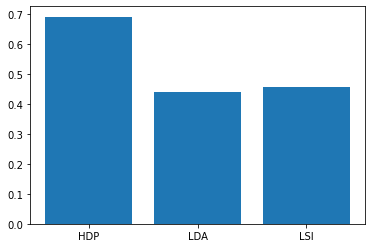

In [18]:
indices = ['HDP', 'LDA', 'LSI']
values = [hdp_coherence,lda_coherence, lsi_coherence]
plt.bar(indices, values)